In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import Matrix
from sympy.abc import rho, gamma, epsilon, u, m

The Euler equations can be linearized by rewriting the flux vector in terms of the state vector, so $m=\rho u$ and $\epsilon=\frac{1}{2}\rho u^2$

In [2]:
X = Matrix([m, rho**gamma+m**2/rho, m*rho**(gamma-1)+epsilon*m/rho])
X

Matrix([
[                                 m],
[             m**2/rho + rho**gamma],
[epsilon*m/rho + m*rho**(gamma - 1)]])

We can then find the jacobian matrix

In [3]:
Y = Matrix([rho, m, epsilon])
J = X.jacobian(Y)
J

Matrix([
[                                                     0,                              1,     0],
[                    gamma*rho**gamma/rho - m**2/rho**2,                        2*m/rho,     0],
[-epsilon*m/rho**2 + m*rho**(gamma - 1)*(gamma - 1)/rho, epsilon/rho + rho**(gamma - 1), m/rho]])

In terms of the old variables the jacobian can be written as

In [4]:
J_p = J.subs(m,rho*u).subs(epsilon, 1/2*rho*u**2)
J_p

Matrix([
[                                        0,                           1, 0],
[              gamma*rho**gamma/rho - u**2,                         2*u, 0],
[rho**(gamma - 1)*u*(gamma - 1) - 0.5*u**3, rho**(gamma - 1) + 0.5*u**2, u]])

With corresponding eigenvalues

In [5]:
J_p.eigenvals()

{u - sqrt(gamma*rho**(gamma + 1))/rho: 1,
 u + sqrt(gamma*rho**(gamma + 1))/rho: 1,
 u: 1}

In [6]:
gamma = 5/3

def conserved_to_primitive(u):
    rho, m = u[:,0], u[:,1]
    return np.array([rho, m/rho, rho**gamma])

def primitive_to_conserved(q):
    rho, u = q[0], q[1]
    return np.array([rho, rho*u, 1/2*rho*u**2])

def get_flux(u):
    rho, m = u[0], u[1]
    rho, u, p = rho, m/rho, rho**gamma
    return np.array([rho*u, p+rho*u**2, (p+0.5*rho*u**2)*u])

def A_conserved(u):
    rho, m, eps = u[0], u[1], u[2]
    return np.array([[0.0, 1.0, 0.0],
                    [gamma*rho**gamma/rho-m**2/rho**2, 2*m/rho, 0 ],
                    [-eps*m/rho**2 + m*rho**(gamma-1)*(gamma-1)/rho, eps/rho+rho**(gamma-1), m/rho]])


def get_initial_conditions(form, resolution, timesteps):  
    # Initial conditions for Sods Shock Tube
    u0L = np.array([1.0, 0.0, 1.0])
    u0R = np.array([0.125, 0.0, 0.1])

    if form=="conserved":
        u0L = primitive_to_conserved(u0L)
        u0R = primitive_to_conserved(u0R)

    u0 = np.zeros((timesteps, resolution, 3))
    half_res = resolution//2
    u0[:,:half_res,0] = u0L[0]
    u0[:,:half_res,1] = u0L[1]
    u0[:,:half_res,2] = u0L[2]
    u0[:,half_res:,0] = u0R[0]
    u0[:,half_res:,1] = u0R[1]
    u0[:,half_res:,2] = u0R[2]

    dt = 0.2/timesteps
    dx = 1/resolution

    q = conserved_to_primitive(u0[0])
    rho, v, p = q[0], q[1], q[2]
    c=np.sqrt(gamma*p/rho) # Speed of sound

    print("dt = {}, dx = {}".format(dt, dx))
    print("CFL Condition: ",dt/dx*np.max(abs(v)+c))

    return u0, dt, dx

def plot_primitives(u, res, index=-1):
    dx = 1/res
    x = np.arange(0,res*dx,dx)
    fig,ax = plt.subplots(3,1, figsize=(8,8))
    u_p = conserved_to_primitive(u[index])
    ax[0].plot(x, u_p[0], linewidth=2, label="Density")
    ax[1].plot(x, u_p[1], linewidth=2, label="Velocity")
    ax[2].plot(x, u_p[2], linewidth=2, label="Pressure")

    ax[0].set_ylabel("$\\rho$")
    ax[1].set_ylabel("$u$")
    ax[2].set_ylabel("$P$")

    ax[0].legend()
    ax[1].legend()
    ax[2].legend()

    ax[0].set_title("Sods Shock Tube at $t={:.2f}$".format(time))
    ax[2].set_xlabel("Position $x$")


# Lax-Wendroff for the Linearized Euler Equations

dt = 0.0002, dx = 0.001
CFL Condition:  0.25819888974716115


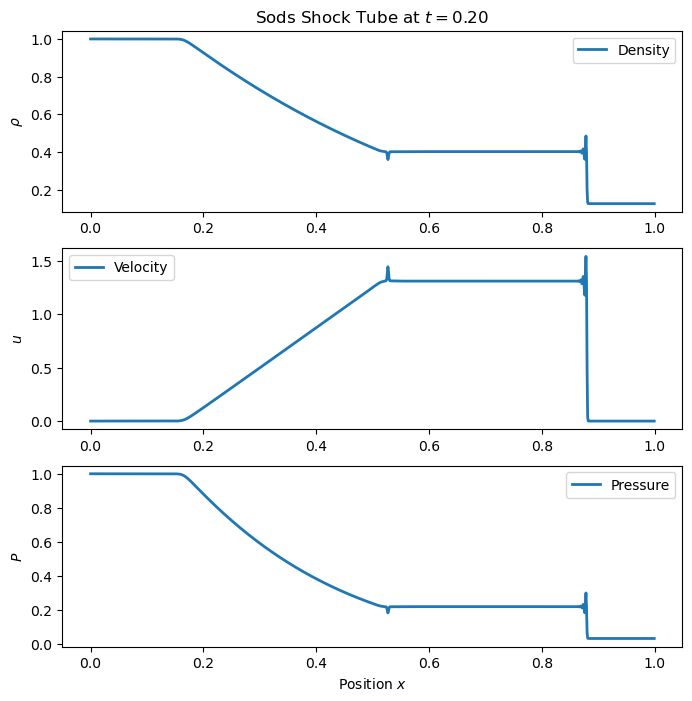

In [7]:
resolution = 1000
timesteps = 1000

u, dt, dx = get_initial_conditions("conserved", resolution, timesteps)

time=dt
break_index = -1

for n in range(timesteps-1):
    time += dt
    for j in range(1,resolution-1):
        # Step 1: Guess
        plus = 0.5*(u[n,j]+u[n,j+1])
        minus = 0.5*(u[n,j]+u[n,j-1])

        # Get linear flows
        A_plus = A_conserved(u[n,j+1])@u[n,j+1]
        A_minus = A_conserved(u[n,j-1])@u[n,j-1]
        A = A_conserved(u[n,j])@u[n,j]

        u_guess_l = plus - dt/(2*dx)*(A_plus - A)
        u_guess_r = minus - dt/(2*dx)*(A - A_minus)

        # Step 2: Evaluate and step forward
        fl = A_conserved(u_guess_l)@u_guess_l
        fr = A_conserved(u_guess_r)@u_guess_r

        u[n+1,j] = u[n,j] - dt/dx*(fl - fr)

    # If unstable stop
    if np.any(np.isnan(u[n+1]))==True:
        print("Break at", n, time)
        break_index = n
        break

plot_primitives(u, resolution, break_index)

# Lax-Wendroff for pure Euler Equations

dt = 0.0002, dx = 0.001
CFL Condition:  0.25819888974716115


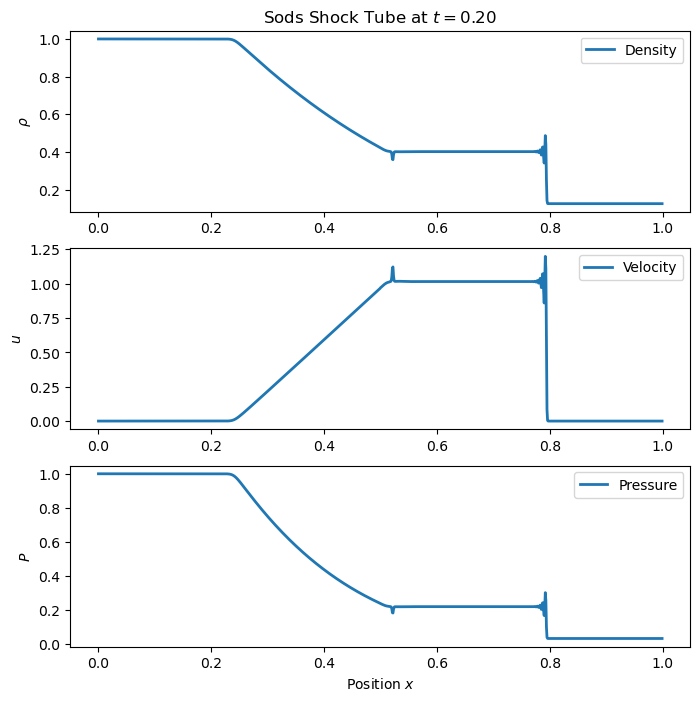

In [9]:
resolution = 1000
timesteps = 1000

u, dt, dx = get_initial_conditions("conserved", resolution, timesteps)

time=dt

for n in range(timesteps-1):
    time += dt
    for j in range(1,resolution-1):
        # Step 1
        flux = get_flux(u[n,j])
        fl = get_flux(u[n,j+1])
        fr = get_flux(u[n,j-1])

        u_guess_l = (u[n,j]+u[n,j+1])/2 - dt/(2*dx)*(fl - flux)        
        u_guess_r = (u[n,j-1]+u[n,j])/2 - dt/(2*dx)*(flux - fr)

        # Step 2
        fl = get_flux(u_guess_l)
        fr = get_flux(u_guess_r)

        u[n+1,j] = u[n,j] - dt/dx*(fl - fr)


plot_primitives(u, resolution, -1)

# Upwind Method

dt = 0.0002, dx = 0.01
CFL Condition:  0.025819888974716113


/tmp/ipykernel_6610/2411662960.py:19: RuntimeWarning: invalid value encountered in double_scalars
  [gamma*rho**gamma/rho-m**2/rho**2, 2*m/rho, 0 ],
/tmp/ipykernel_6610/2411662960.py:20: RuntimeWarning: invalid value encountered in double_scalars
  [-eps*m/rho**2 + m*rho**(gamma-1)*(gamma-1)/rho, eps/rho+rho**(gamma-1), m/rho]])
/tmp/ipykernel_6610/2411662960.py:19: RuntimeWarning: overflow encountered in double_scalars
  [gamma*rho**gamma/rho-m**2/rho**2, 2*m/rho, 0 ],
/tmp/ipykernel_6610/2411662960.py:20: RuntimeWarning: overflow encountered in double_scalars
  [-eps*m/rho**2 + m*rho**(gamma-1)*(gamma-1)/rho, eps/rho+rho**(gamma-1), m/rho]])
/tmp/ipykernel_6610/2243066521.py:21: RuntimeWarning: invalid value encountered in matmul
  fl = A_conserved(u[n,j+1])@u[n,j+1]
/tmp/ipykernel_6610/2243066521.py:22: RuntimeWarning: invalid value encountered in matmul
  fr = A_conserved(u[n,j])@u[n,j]


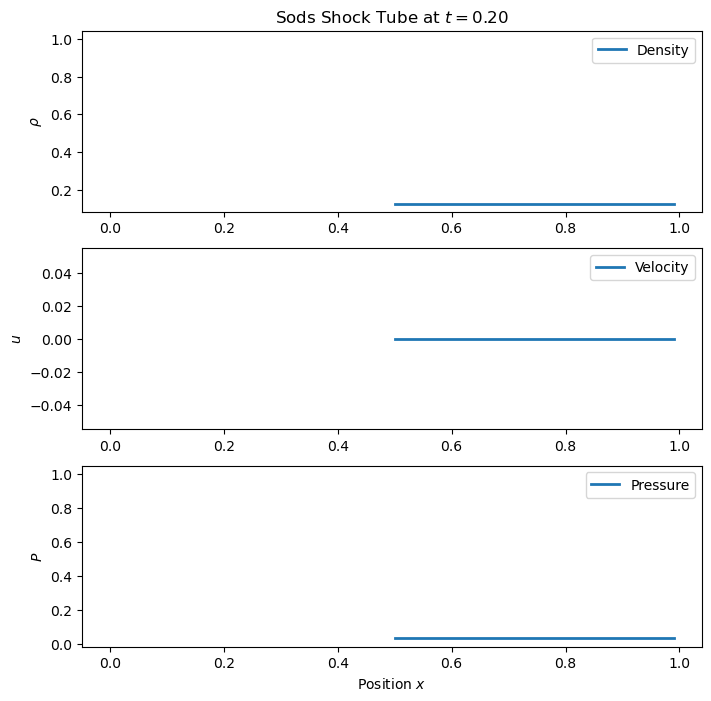

In [24]:
from scipy.linalg import eig
def get_eigenvals(u):
    rho, m = u[0], u[1]
    rho, u, p = rho, m/rho, rho**gamma
    return np.array([u-np.sqrt(gamma*rho**(gamma+1))/rho, u+np.sqrt(gamma*rho**(gamma+1))/rho, u])

resolution = 100
timesteps = 1000

u, dt, dx = get_initial_conditions("conserved", resolution, timesteps)

time=dt

for n in range(timesteps-1):
    time += dt
    for j in range(1,resolution-1):
        """print("first", A_conserved(u[n,j]))
        L, R = eig(A_conserved(u[n,j]), right=True, left=False)
        print("second", np.linalg.inv(R)@np.diag(L)@R)"""

        fl = A_conserved(u[n,j+1])@u[n,j+1]
        fr = A_conserved(u[n,j])@u[n,j]

        u[n+1,j] = u[n,j] - dt/dx*(fl - fr)

plot_primitives(u, resolution)

# Leap-Frog Method

/tmp/ipykernel_461/1201697547.py:24: RuntimeWarning: overflow encountered in double_scalars
  u, p, E= m/rho, (eps - 0.5*m**2/rho)*(gamma-1), eps/rho
/tmp/ipykernel_461/1201697547.py:24: RuntimeWarning: invalid value encountered in double_scalars
  u, p, E= m/rho, (eps - 0.5*m**2/rho)*(gamma-1), eps/rho


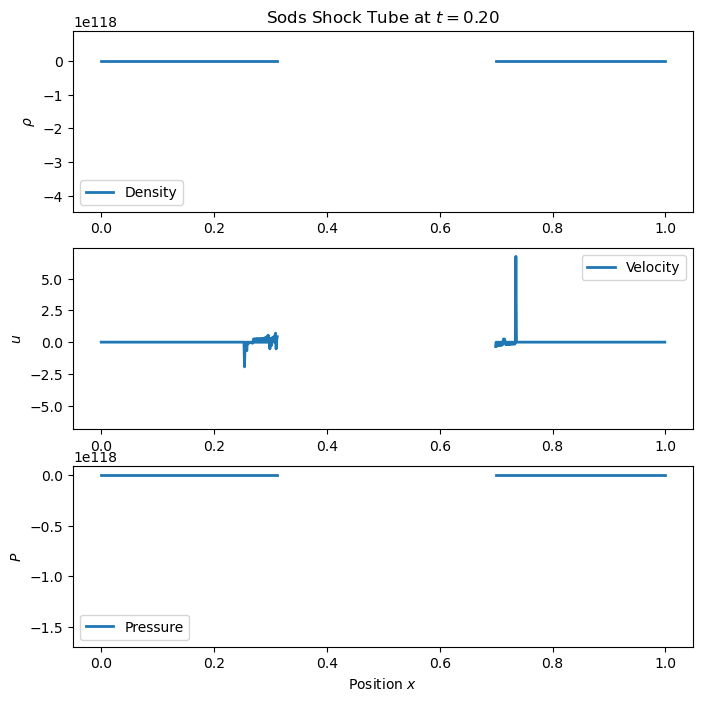

In [ ]:
resolution = 1000
timesteps = 1000

dt = 0.2/timesteps
dx = 1/resolution

u = get_initial_conditions("conserved", resolution, timesteps)

time=dt

for n in range(1,timesteps-1):
    time += dt
    for j in range(1,resolution-1):
        fl = get_flux(u[n,j+1])
        fr = get_flux(u[n,j-1])

        u[n+1,j] = u[n-1,j] - dt/(2*dx)*(fl - fr)

plot_primitives(u, resolution)

# Some Animation fun

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib tk
fig,ax = plt.subplots(3,1, figsize=(10,8))

xdata = np.arange(0,resolution*dx,dx)

#u = u[::5]

u_p = conserved_to_primitive(u[0])
"""
ax[0].set_ylim(0, 1.2)
ax[1].set_ylim(0, 1.4)
ax[2].set_ylim(0, 1.2)"""

ln1, = ax[0].plot(xdata, u_p[0])
ln2, = ax[1].plot(xdata, u_p[1])
ln3, = ax[2].plot(xdata, u_p[2])

def init():
    ax[0].set_ylim(0, 1.3)
    ax[1].set_ylim(0, 1.3)
    ax[2].set_ylim(0, 1.3)
    return ln1, ln2, ln3,

def update(frame):
    u_p = conserved_to_primitive(u[frame])
    ln1.set_data(xdata, u_p[0])
    ln2.set_data(xdata, u_p[1])
    ln3.set_data(xdata, u_p[2])
    return ln1, ln2, ln3

ani = FuncAnimation(fig, update, init_func=init, frames=timesteps//5, interval=1)
ani.save("sods_shock.gif")

In [ ]:
new_u = np.array([conserved_to_primitive(u[i]) for i in range(1000)])
plt.imshow(new_u[:,1,], aspect="auto")#.shape